In [12]:
_ = """
1. Feature importance meesures based on RF:
    a) impurities based on measures
    b) permutations based on measures

2. Boruta algorithm (POSLA GUROM) - to niżej to nie jest 100% poprawne:
    default variables + "shadow" variables
    default scores + "shadow" scores

    Use random forest

    if some default score is bigger then max(shadow_scores):
        variable is important (stay)
    elif some default score is lower then min(shadow_scores):
        variable is not important (to delete)
    else:
        we do not have knowledge about the variable

    Repeat until all variable will be deleted or stay
"""


TODO:
pip install Boruta

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

from boruta import BorutaPy



In [3]:
def get_dataset_1(
        size: int,
        features: int,
        significant_features: int
        ) -> tuple[np.array, np.array]:

    X = np.random.normal(0, 1, size=(size, features))

    chi2_median = chi2.ppf(0.5, significant_features)

    X_k = X[:, :significant_features]
    X_k_sumsq = np.sum(X_k ** 2, axis=1)

    Y = (X_k_sumsq > chi2_median).astype(int)

    return X, Y


def get_dataset_2(
        size: int,
        features: int,
        significant_features: int
        ) -> tuple[np.array, np.array]:

    X = np.random.normal(0, 1, size=(size, features))

    X_k = X[:, :significant_features]
    X_k_sum_abs = np.sum(np.abs(X_k), axis=1)

    Y = (X_k_sum_abs > significant_features).astype(int)

    return X, Y


def get_random_forest_features(
        x: np.array,
        y: np.array,
        n: int
        ) -> list[tuple[str, float]]:
    """
    Input:
     * x: np.array - features of dataset
     * y: np.array - binary labels of dataset
     * n: int - how many the best scores return

    Output:
     * list[tuple[str, float]] - list with results.
        Every tuple represent featurer name and the score
    """

    feature_names = [f"feature {i}" for i in range(x.shape[1])]
    forest = RandomForestClassifier(random_state=0)
    forest.fit(x, y)

    feature_importances = forest.feature_importances_

    forest_importances = {
        feature_names[i]: feature_importances[i]
        for i in range(len(feature_names))
    }

    sorted_features = sorted(
        forest_importances.items(),
        key=lambda x:x[1],
        reverse=True
        )
    
    return sorted_features[:n]


def get_boruta_features(
        x: np.array,
        y: np.array
        ) -> list[tuple[str, float]]:
    """
    Input:
     * x: np.array - features of dataset
     * y: np.array - binary labels of dataset

    Output:
     * list[tuple[str, float]] - list with results.
        Every tuple represent featurer name and the score
    """

    rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
    boruta_model = BorutaPy(rf, n_estimators="auto")
    boruta_model.fit(x, y)

    feature_names = [f"feature {i}" for i in range(x.shape[1])]
    feature_importances = boruta_model.support_

    the_best_features = [
        (feature_names[i], 1.0)
        for i in range(len(feature_names))
        if feature_importances[i] == True
    ]

    return the_best_features


def check_dataset(
        X: np.array,
        y: np.array,
        significant_features: list[str],
        print_: bool = True
        ) -> tuple[int, int]:

    boruta_features = get_boruta_features(X, y)
    rf_feafuter = get_random_forest_features(X, y, len(boruta_features))

    b_names = [f[0] for f in boruta_features]
    rf_names = [f[0] for f in rf_feafuter]

    if print_:
        print("Feature name\tBoruta\tRForest\tSignificant")
        print("-"*43)

    b_results = 0
    rf_results = 0

    for feature in sorted(set(significant_features + b_names + rf_names)):
        b_exists = True if feature in b_names else " "
        rf_exits = True if feature in rf_names else " "
        is_significant = True if feature in significant_features else " "

        if feature in significant_features and feature in b_names:
            b_results += 1
        
        if feature in significant_features and feature in rf_names:
            rf_results += 1

        if print_:
            print(feature, b_exists, rf_exits, is_significant, sep="\t")

    return b_results, rf_results


In [4]:
X1, y1 = get_dataset_1(100, 50, 10)
X2, y2 = get_dataset_1(100, 50, 10)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)


In [5]:
feature_names = [f"feature {i}" for i in range(X1.shape[1])]
significant_features = feature_names[:10]


# (a) Check if the considered algorithms assign the highest variable importance scores to the significant variables

In [6]:
_ = check_dataset(X1, y1, significant_features)


Feature name	Boruta	RForest	Significant
-------------------------------------------
feature 0	True	True	True
feature 1	 	 	True
feature 2	 	 	True
feature 3	 	 	True
feature 4	 	 	True
feature 5	 	 	True
feature 6	 	 	True
feature 7	 	 	True
feature 8	True	True	True
feature 9	 	 	True


In [7]:
_ = check_dataset(X2, y2, significant_features)


Feature name	Boruta	RForest	Significant
-------------------------------------------
feature 0	 	 	True
feature 1	 	 	True
feature 2	 	 	True
feature 22	 	True	 
feature 23	True	 	 
feature 28	True	True	 
feature 3	 	 	True
feature 4	 	 	True
feature 43	True	True	 
feature 5	 	 	True
feature 6	 	 	True
feature 7	 	 	True
feature 8	 	 	True
feature 9	True	True	True


Conclusions: Sometimes yes, sometimes no :/

# (b) Try different values of n, p and k. First, you can use values: n = 500, p = 50 and k = 10.

In [8]:
k = 10

X1, y1 = get_dataset_1(500, 50, k)
X2, y2 = get_dataset_1(500, 50, k)

feature_names = [f"feature {i}" for i in range(X1.shape[1])]
significant_features = feature_names[:k]

_ = check_dataset(X1, y1, significant_features)

print()
print()

_ = check_dataset(X2, y2, significant_features)


Feature name	Boruta	RForest	Significant
-------------------------------------------
feature 0	True	True	True
feature 1	True	True	True
feature 2	True	True	True
feature 3	True	True	True
feature 4	True	True	True
feature 5	True	True	True
feature 6	True	True	True
feature 7	True	True	True
feature 8	True	True	True
feature 9	True	True	True


Feature name	Boruta	RForest	Significant
-------------------------------------------
feature 0	True	True	True
feature 1	True	True	True
feature 2	True	True	True
feature 21	True	True	 
feature 3	True	True	True
feature 4	True	True	True
feature 5	True	True	True
feature 6	True	True	True
feature 7	True	True	True
feature 8	True	True	True
feature 9	True	True	True


# (c) Repeat data generation process L = 50 times and estimate the probabilities of correct ordering, i.e. compute the fraction of simulations in which the significant variables are selected as relevant or are placed on the top of the ranking list. Take smaller L if simulations are too expensive computationally.

In [9]:
feature_names = [f"feature {i}" for i in range(X1.shape[1])]
significant_features = feature_names[:k]

boruta_acc_ds1 = []
rforest_acc_ds1 = []

boruta_acc_ds2 = []
rforest_acc_ds2 = []

for _ in range(50):
    X1, y1 = get_dataset_1(100, 50, 10)
    X2, y2 = get_dataset_1(100, 50, 10)

    b_results, rf_results = check_dataset(X1, y1, significant_features, False)

    boruta_acc_ds1.append(b_results)
    rforest_acc_ds1.append(rf_results)

    b_results, rf_results = check_dataset(X2, y2, significant_features, False)

    boruta_acc_ds2.append(b_results)
    rforest_acc_ds2.append(rf_results)


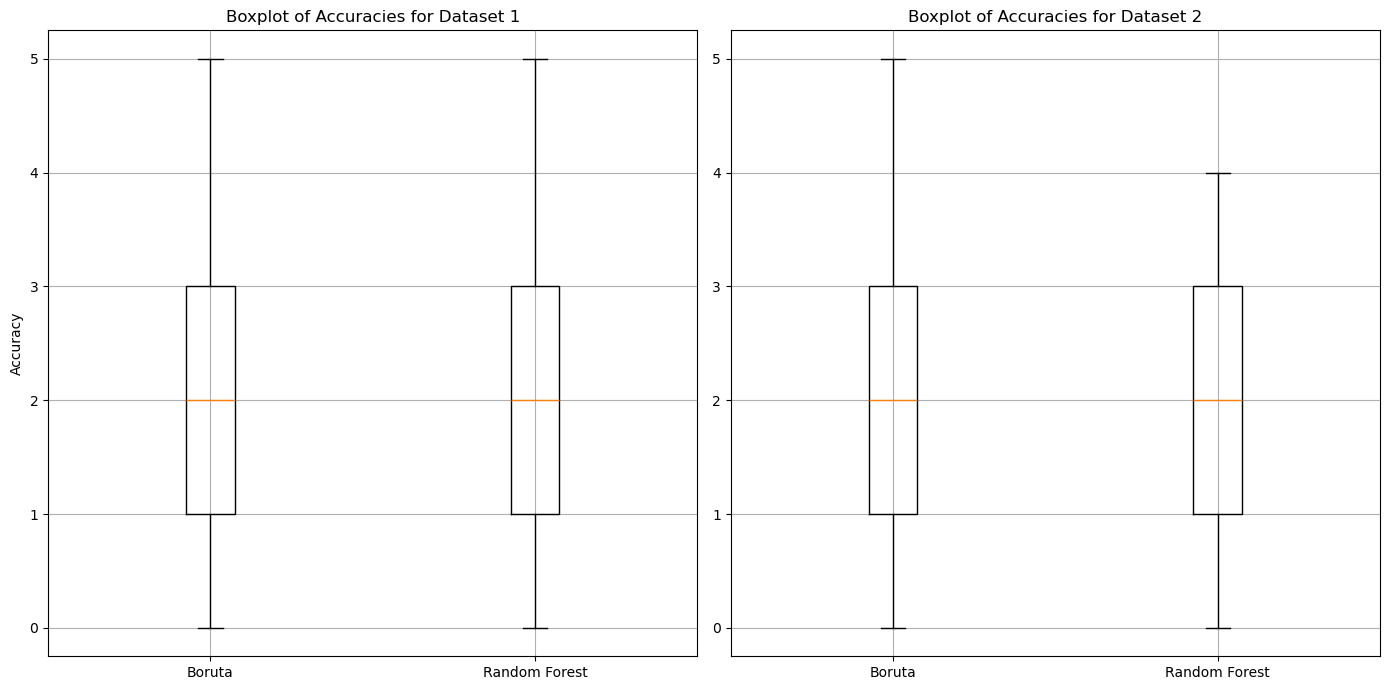

In [16]:
plt.figure(figsize=(14, 7))

# Dataset 1
plt.subplot(1, 2, 1)
plt.boxplot([boruta_acc_ds1, rforest_acc_ds1], labels=['Boruta', 'Random Forest'])
plt.title('Boxplot of Accuracies for Dataset 1')
plt.ylabel('Accuracy')
plt.grid(True)

# Dataset 2
plt.subplot(1, 2, 2)
plt.boxplot([boruta_acc_ds2, rforest_acc_ds2], labels=['Boruta', 'Random Forest'])
plt.title('Boxplot of Accuracies for Dataset 2')
plt.grid(True)

plt.tight_layout()
plt.show()

# d) Fix n = 2000, p = 500, k = 20. Let t denote the number of top-ranked features according to the considered feature importance measure. Train the classifier (e.g. random forest) using t top-ranked features and analyze how the classification accuracy depends on t = 5, 10, 15, 20, 50, 100, 200, 300, 400, 500. Generate a plot showing the dependence.

In [10]:
t_list = (5, 10, 15, 20, 50, 100, 200, 300, 400, 500)

X1, y1 = get_dataset_1(2000, 500, 20)
X2, y2 = get_dataset_1(2000, 500, 20)

# Las na wsyzstkich zmiennych i wyciągnąć istotność kolumn
feature_names = [f"feature {i}" for i in range(X1.shape[1])]
forest = RandomForestClassifier()
forest.fit(X1, y1)

feature_importances = forest.feature_importances_

for t in t_list:
    feature_names = [f"feature {i}" for i in range(X1.shape[1])]
    forest = RandomForestClassifier()
    forest.fit(X1[:, :t], y1)

    feature_importances = forest.feature_importances_

    forest_importances = {
        feature_names[i]: feature_importances[i]
        for i in range(len(feature_names))
    }

    sorted_features = sorted(
        forest_importances.items(),
        key=lambda x:x[1],
        reverse=True
        )


NameError: name 'X' is not defined

# TODO: zrobić wykres, x to 't', Y to 'accuracy'. Po t=20 powinno nie rosnąć